# 평가 조건
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.	
    - 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.
2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.
    - 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.
3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.
    - 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

# 모듈 임포트

In [1]:
import tensorflow as tf
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

# 데이터 불러오기

In [2]:
chatbot_file_path=os.getenv('HOME') + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
data = pd.read_csv(chatbot_file_path, encoding = 'utf-8')
data.tail()

,Q,A,label
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2
11822,힘들어서 결혼할까봐,도피성 결혼은 하지 않길 바라요.,2


In [3]:
len(data)

11823

- 데이터는 총 11823개가 있습니다.

In [4]:
data.isna().sum()

Q        0
A        0
label    0
dtype: int64

- 데이터에 결측치는 없는것으로 확인됩니다.

# 데이터 전처리하기 

In [5]:
# 전처리 함수
def preprocess_data(data):
    
    questions = []
    
    for sentence in tqdm(data['Q']):
        # 예를 들어서 "흑기사 해주는 짝남." => "흑기사 해주는 짝남 ."와 같이 짝남과 온점 사이에 공백을 만들어줌
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) #여러개의 공백을 하나의 공백으로 만들어줌
        sentence = sentence.strip()
        questions.append(sentence)
        
    answers = []
    
    for sentence in tqdm(data['A']):
        # 예를 들어서 "흑기사 해주는 짝남." => "흑기사 해주는 짝남 ."와 같이 짝남과 온점 사이에 공백을 만들어줌
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence) #여러개의 공백을 하나의 공백으로 만들어줌
        sentence = sentence.strip()
        answers.append(sentence)
    
    return questions, answers

In [6]:
questions_data, answers_data = preprocess_data(data)

100%|██████████| 11823/11823 [00:00<00:00, 174498.23it/s]


In [7]:
print('전처리 후의 1번째 질문 샘플: {}'.format(questions_data[0]))
print('전처리 후의 1번째 답변 샘플: {}'.format(answers_data[0]))

전처리 후의 1번째 질문 샘플: 12시 땡 !
전처리 후의 1번째 답변 샘플: 하루가 또 가네요 .


- 전처리가 잘된것을 볼 수 있습니다.

# 단어사전 만들기

In [8]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions_data + answers_data, target_vocab_size=2**13)

- tfds.deprecated.text.SubwordTextEncoder.build_from_corpus는 TensorFlow Datasets의 SubwordTextEncoder 클래스를 사용하여 주어진 코퍼스(corpus)로부터 Subword 토크나이저를 만드는 함수입니다.
- Subword 토크나이저는 단어를 하위 단위(Subword)로 분해하는 기법입니다. 이를 통해, 희귀 단어나 미등록어(out-of-vocabulary) 문제를 해결할 수 있습니다. SubwordTextEncoder 클래스는 Byte Pair Encoding(BPE) 알고리즘을 사용하여 Subword 토크나이저를 생성합니다.

In [9]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [11]:
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 77번째 질문 샘플: {}'.format(tokenizer.encode(questions_data[77])))
print('정수 인코딩 후의 77번째 답변 샘플: {}'.format(tokenizer.encode(answers_data[77])))

정수 인코딩 후의 77번째 질문 샘플: [80, 158, 4661, 1552, 26]
정수 인코딩 후의 77번째 답변 샘플: [6131, 2694, 31, 44, 1]


In [12]:
#정수로 변환된 것을 다시 디코딩하여 원래의 문장으로 변환
print('정수 디코딩 후의 77번째 질문 샘플: {}'.format(tokenizer.decode([80, 158, 4661, 1552, 26])))
print('정수 디코딩 후의 77번째 답변 샘플: {}'.format(tokenizer.decode([6131, 2694, 31, 44, 1])))

정수 디코딩 후의 77번째 질문 샘플: 같이 있으면 힘든데 붙잡고 싶어
정수 디코딩 후의 77번째 답변 샘플: 질질 끌지 마세요 .


- 인코딩과 디코딩이 잘 되는것으로 보아 토큰화가 제대로 수행된것을 알 수 있습니다.

# 데이터 패딩하기

질문 최소 길이: 1
질문 평균 길이: 3.9402858834475176
질문 최대 길이: 16
---------------------------------------------------------------------------
답변 최소 길이: 1
답변 평균 길이: 4.71589275141673
답변 최대 길이: 24


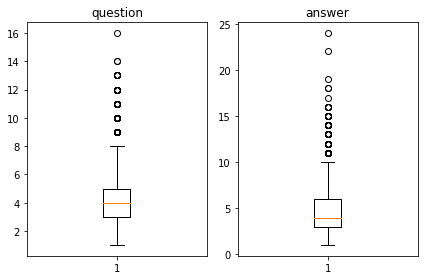

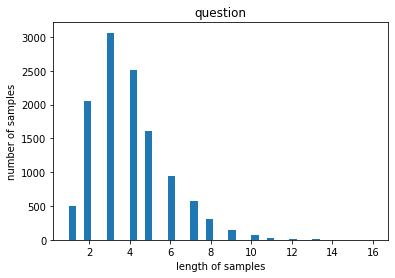

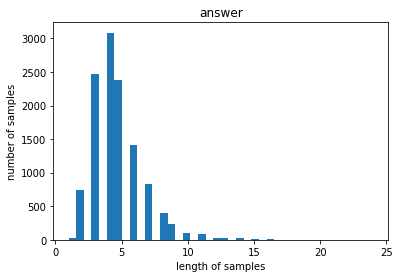

In [13]:
#길이 분포 출력

question_len = [len(s.split()) for s in questions_data]
answer_len = [len(s.split()) for s in answers_data]

print('질문 최소 길이: {}'.format(np.min(question_len)))
print('질문 평균 길이: {}'.format(np.mean(question_len)))
print('질문 최대 길이: {}'.format(np.max(question_len)))
print('-----'*15)
print('답변 최소 길이: {}'.format(np.min(answer_len)))
print('답변 평균 길이: {}'.format(np.mean(answer_len)))
print('답변 최대 길이: {}'.format(np.max(answer_len)))

plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('question')
plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('answer')
plt.tight_layout()
plt.show()

plt.title('question')
plt.hist(question_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answer')
plt.hist(answer_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 질문과 답변이 10이하에 많이 분포되어 있어서 max_len를 10으로 설정하고자 한다.

In [14]:
MAX_LENGTH = 10

In [15]:
def len_control(max_len, data_list):
    c = 0
    for s in data_list:
        if len(s.split()) < max_len:
            c += 1
    print('전체 데이터 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (c/len(data_list))))

In [16]:
len_control(MAX_LENGTH, questions_data)
len_control(MAX_LENGTH, answers_data)

전체 데이터 중 길이가 10 이하인 샘플의 비율: 0.9899348727057431
전체 데이터 중 길이가 10 이하인 샘플의 비율: 0.9769939947559841


- 길이가 10이하인 질문과 답변 모두 약 97%이상 되는것을 확인하였다.
- 질문과 답변 앞 뒤로 start, end token을 넣어주고, max_len를 기준으로 패딩을 해주었다. 

In [17]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in tqdm(zip(inputs, outputs)):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 10 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 10으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [18]:
questions, answers = tokenize_and_filter(questions_data, answers_data)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

11823it [00:00, 26171.54it/s]

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 9098
필터링 후의 답변 샘플 개수: 9098


- 11823개의 데이터에서 9098개의 데이터로 줄었다. 
- 길이가 10이하인 데이터들만 잘 모인것을 알 수 있다.

# 데이터 변환 및 셔플링

In [19]:
BATCH_SIZE = 128
BUFFER_SIZE = len(questions)

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 정의
- 트랜스포머에 사용되는 함수들을 정의하도록 하겠습니다.

## 포지셔널 인코딩(PositionalEncoding)

In [20]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## 스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)

In [21]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

## 멀티 헤드 어텐션(MultiHeadAttention)

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## 패딩 마스킹(padding_mask)

In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

## 룩 어헤드 마스킹(look_ahead_mask)

In [24]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

## 인코더(encoder_layer)

In [25]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
            d_model, num_heads, name="attention")({
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': padding_mask
          })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [26]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 디코더(decoder_layer)

In [27]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [28]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 트랜스포머(transformer)

In [29]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
        )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
        )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [30]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.3 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    4201216     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

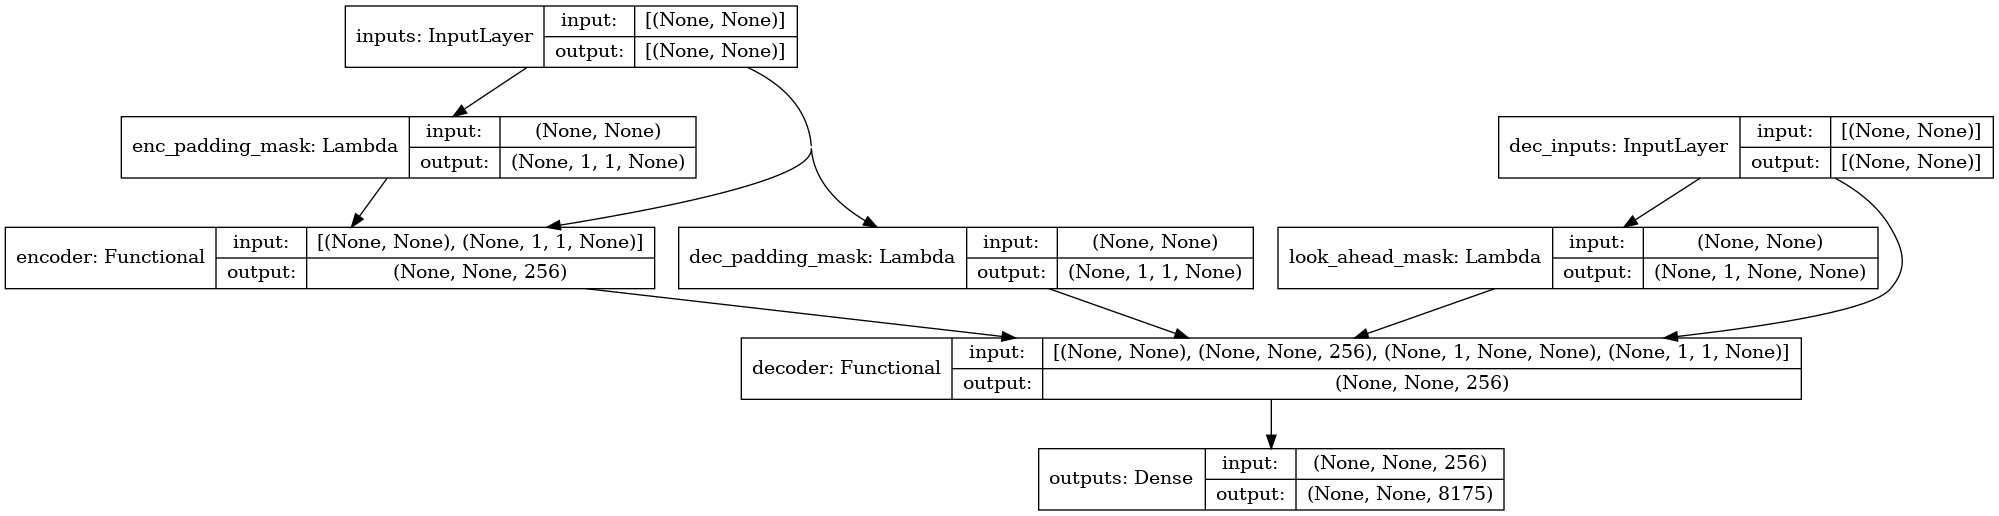

In [31]:
plot_model(model, show_shapes=True)

- 복잡해 보이지만 그래도 모델이 잘 만들어진것을 알 수 있습니다.

### 손실함수

In [32]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 커스텀 된 학습률(Learning rate)

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 모델 컴파일

In [34]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 모델 훈련하기

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=1, restore_best_weights=True)

EPOCHS = 300

history = model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[es])

Epoch 1/300
72/72 [==============================] - 27s 61ms/step - loss: 5.8515 - accuracy: 0.0524
Epoch 2/300
72/72 [==============================] - 4s 60ms/step - loss: 5.4213 - accuracy: 0.1113
Epoch 3/300
72/72 [==============================] - 4s 59ms/step - loss: 5.0462 - accuracy: 0.1111
Epoch 4/300
72/72 [==============================] - 4s 59ms/step - loss: 4.5861 - accuracy: 0.1354
Epoch 5/300
72/72 [==============================] - 4s 59ms/step - loss: 4.0880 - accuracy: 0.2130
Epoch 6/300
72/72 [==============================] - 4s 59ms/step - loss: 3.8094 - accuracy: 0.2156
Epoch 7/300
72/72 [==============================] - 4s 60ms/step - loss: 3.6295 - accuracy: 0.2162
Epoch 8/300
72/72 [==============================] - 4s 59ms/step - loss: 3.4930 - accuracy: 0.2182
Epoch 9/300
72/72 [==============================] - 4s 59ms/step - loss: 3.3902 - accuracy: 0.2228
Epoch 10/300
72/72 [==============================] - 4s 59ms/step - loss: 3.3143 - accuracy: 0.226

72/72 [==============================] - 4s 59ms/step - loss: 0.1127 - accuracy: 0.6334
Epoch 83/300
72/72 [==============================] - 4s 59ms/step - loss: 0.1024 - accuracy: 0.6371
Epoch 84/300
72/72 [==============================] - 4s 59ms/step - loss: 0.1029 - accuracy: 0.6370
Epoch 85/300
72/72 [==============================] - 4s 59ms/step - loss: 0.0988 - accuracy: 0.6375
Epoch 86/300
72/72 [==============================] - 4s 58ms/step - loss: 0.0973 - accuracy: 0.6375
Epoch 87/300
72/72 [==============================] - 4s 59ms/step - loss: 0.0919 - accuracy: 0.6392
Epoch 88/300
72/72 [==============================] - 4s 59ms/step - loss: 0.0962 - accuracy: 0.6383
Epoch 89/300
72/72 [==============================] - 4s 59ms/step - loss: 0.0904 - accuracy: 0.6397
Epoch 90/300
72/72 [==============================] - 4s 59ms/step - loss: 0.0880 - accuracy: 0.6400
Epoch 91/300
72/72 [==============================] - 4s 59ms/step - loss: 0.0856 - accuracy: 0.6409
Epo

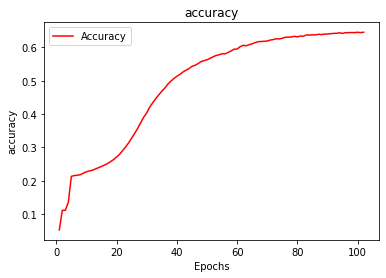

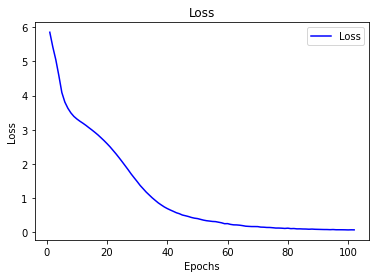

In [37]:
history_dict = history.history

acc = history_dict['accuracy']
loss = history_dict['loss']

his_epochs = range(1, len(loss) + 1)

plt.plot(his_epochs, acc, 'r', label='Accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

plt.clf() #그림 초기화

plt.plot(his_epochs, loss, 'b', label='Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- accuracy는 우상향, loss는 우하향하는 모습을 보여주고 있습니다.

# 챗봇 테스트하기

In [45]:
def preprocess(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [46]:
def decoder_inference(sentence):
    sentence = preprocess(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [47]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [48]:
sentence_generation('오늘 점심 뭐먹지?')

입력 : 오늘 점심 뭐먹지?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [57]:
sentence_generation('다이어트 할거야')

입력 : 다이어트 할거야
출력 : 너무 무리하지는 마세요 .


'너무 무리하지는 마세요 .'

In [61]:
sentence_generation('오늘 점심 메뉴 추천해줘')

입력 : 오늘 점심 메뉴 추천해줘
출력 : 냉장고 파먹기 해보세요 .


'냉장고 파먹기 해보세요 .'

In [62]:
sentence_generation('학교 가기 귀찮아')

입력 : 학교 가기 귀찮아
출력 : 학교 다닐 때가 좋은 거예요 .


'학교 다닐 때가 좋은 거예요 .'

In [65]:
sentence_generation('등산하고 싶어')

입력 : 등산하고 싶어
출력 : 같이 등산해요 .


'같이 등산해요 .'

- 생각보다 질문에 관련된 답변을 하는 것을 볼 수 있습니다.

# 전체 회고

- 전체적으로 잘 진행된 프로젝트였습니다.
- 평가 조건은 무리없이 달성했다고 생각합니다
- 트랜스포머에 대한 이론적인 부분은 이해가 가지만, 코드적으로는 좀 더 공부를 해야겠다는 생각이 들었습니다.
- 데이터의 질문과 답변이 다양했다면, 더 좋은 답변이 나올수도 있었다고 생각됩니다.

# 참고자료

- https://velog.io/@seolini43/%ED%8C%8C%EC%9D%B4%EC%8D%ACTransformer%EB%A1%9C-%EC%98%A4%ED%94%BC%EC%8A%A4-%EC%B1%97%EB%B4%87-%EB%A7%8C%EB%93%A4%EA%B8%B0-%EC%BD%94%EB%93%9C
- https://undeadkwandoll.tistory.com/29